In [ ]:
# import libraries

import pandas as pd
import numpy as np
import string
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
%matplotlib inline
import re
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from multiprocessing import Pool, cpu_count
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import Model
# Download necessary NLTK data files
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Background and Motivation**

Mental health is a fundamental aspect of overall well-being, affecting how individuals think, feel, and act. With the increasing prevalence of mental health disorders such as depression, anxiety, and stress, there is a growing need for innovative solutions to monitor and address these issues proactively. Traditional methods of mental health assessment often rely on self-reported surveys and clinical evaluations, which can be time-consuming and may not capture real-time fluctuations in an individual's emotional state.

**Objective**

This project aims to harness the power of sentiment analysis, a subset of natural language processing (NLP), to monitor mental health through textual data. Sentiment analysis involves the use of algorithms and machine learning techniques to identify and extract subjective information from text, categorizing it as positive, negative, or neutral. By applying sentiment analysis to text data from various sources, we can gain valuable insights into the emotional and mental states of individuals.

In today's fast-paced world, mental health has emerged as a critical area of concern, impacting millions globally. The advent of digital communication, particularly through social media and online forums, has provided a unique window into the collective psyche of individuals, offering valuable insights into their emotional and mental states. Our project leverages sentiment analysis, a powerful tool in the field of natural language processing (NLP), to monitor and assess mental health trends through textual data.

The primary objective of this project is to develop a robust model that can accurately classify text based on sentiment, helping to identify early signs of mental health issues such as anxiety, depression, and stress. By analyzing data from various sources, including social media posts, forums, and mental health support groups, our model aims to provide real-time insights into the emotional well-being of individuals.

Through this project, we aim to demonstrate how sentiment analysis can be an effective tool in mental health monitoring, offering a proactive approach to mental health care. By identifying negative sentiment patterns early, we can potentially facilitate timely interventions and support, ultimately contributing to better mental health outcomes.

# import the file and Let's begin !

In [ ]:
df=pd.read_csv('/content/Combined Data.csv')
df.head(10)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,7,Have you ever felt nervous but didn't know why?,Anxiety
8,8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,9,"I'm really worried, I want to cry.",Anxiety


In [ ]:
df.tail(10)

,Unnamed: 0,statement,status
53033,53033,I'm an adult who can not sleep alone. So I'm 3...,Anxiety
53034,53034,Neighbours Hello I’m haveing anxiety because ...,Anxiety
53035,53035,"Oxazepam? Hey! I have been taking oxazepam 7,5...",Anxiety
53036,53036,someone help me think rationally I know I soun...,Anxiety
53037,53037,Lorazepam side effect/after effect In the last...,Anxiety
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety
53042,53042,I have really bad door anxiety! It's not about...,Anxiety


In [ ]:
print(df.isnull().sum())

Unnamed: 0      0
statement     362
status          0
dtype: int64


In [ ]:
df = df.dropna()
print(df.isnull().sum())

Unnamed: 0    0
statement     0
status        0
dtype: int64


In [ ]:
df['status'].nunique()

7

Let us understand the data

In [ ]:
sentiment_counts=df['status'].value_counts()
print(sentiment_counts)

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

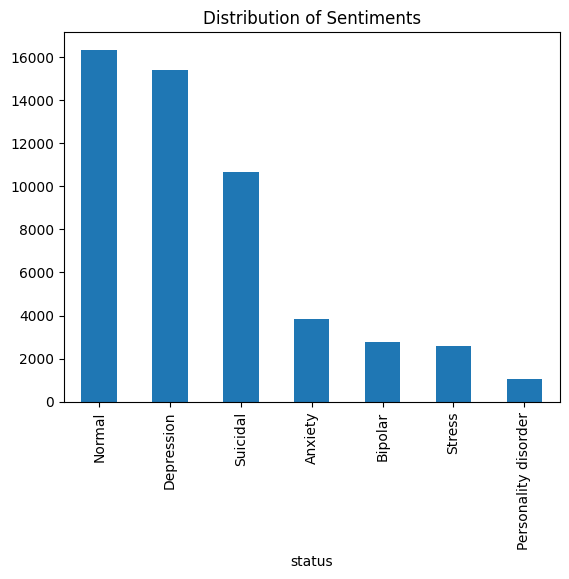

In [ ]:
sentiment_counts.plot(kind='bar', title='Distribution of Sentiments')

In [ ]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

This will be our target for classifying text into the above groups. Once our model is trained with the data, we can use it to correctly classify new text input into these categories and take preventive actions to help the people with these mental health issues.

In [ ]:
df.shape

(52681, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  52681 non-null  int64 
 1   statement   52681 non-null  object
 2   status      52681 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
df.describe()

,Unnamed: 0
count,52681.000000
mean,26365.706042
std,15235.065306
min,0.000000
25%,13180.000000
50%,26350.000000
75%,39522.000000
max,53042.000000


Drop these rows with missing values

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: statement_length, dtype: float64


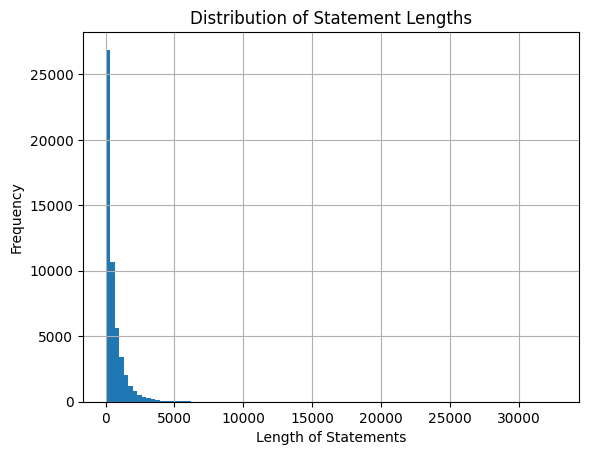

In [ ]:
# Calculate the length of each statement
df['statement_length'] = df['statement'].apply(len)

# Display basic statistics of statement lengths
print(df['statement_length'].describe())

# Plot the distribution of statement lengths
df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

let us get a more clear picture of this column excluding the outliers

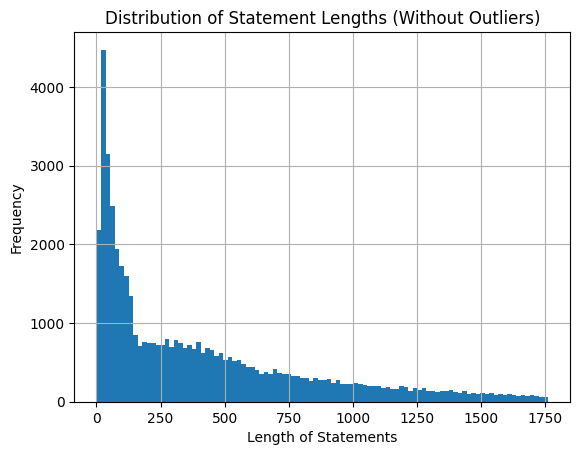

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['statement_length'].quantile(0.25)
Q3 = df['statement_length'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(df['statement_length'] >= lower_bound) & (df['statement_length'] <= upper_bound)]
# Plot the distribution of statement lengths without outliers
filtered_df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

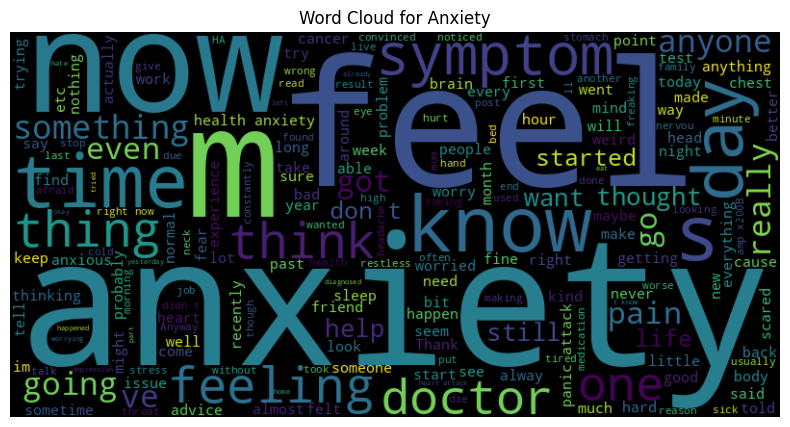

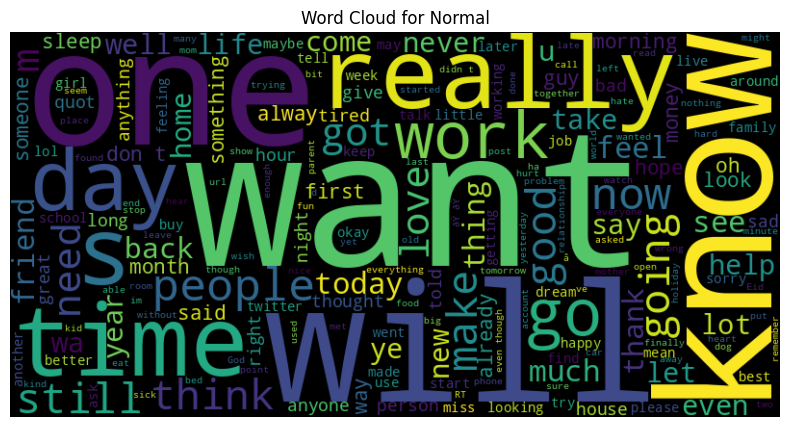

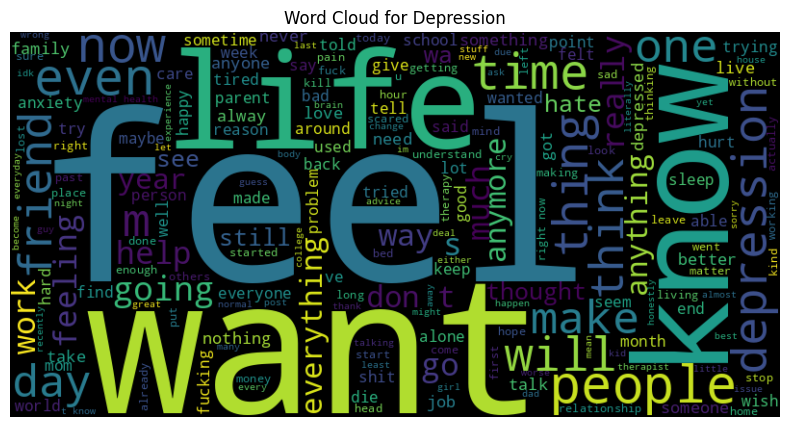

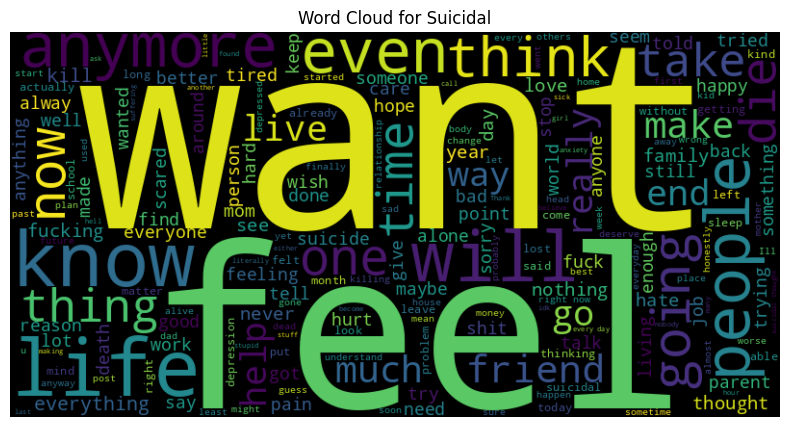

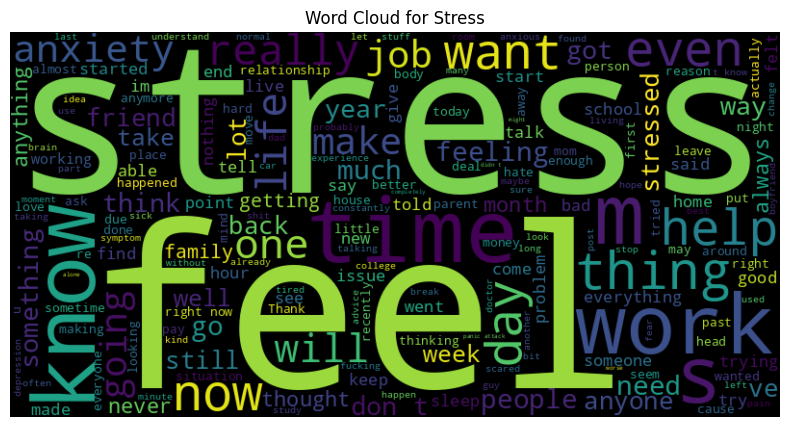

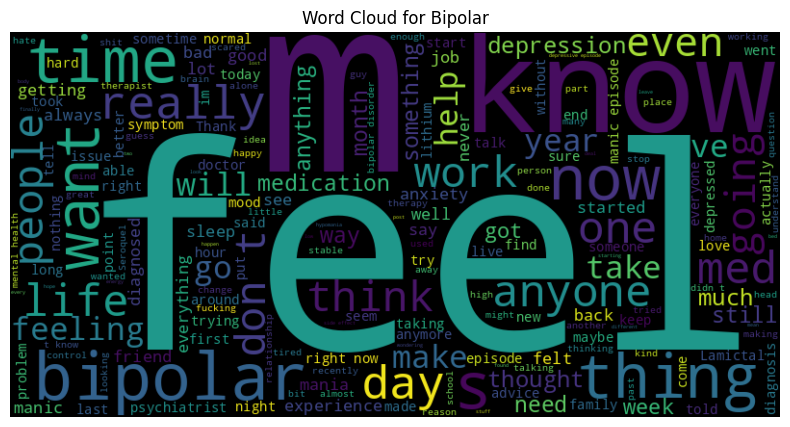

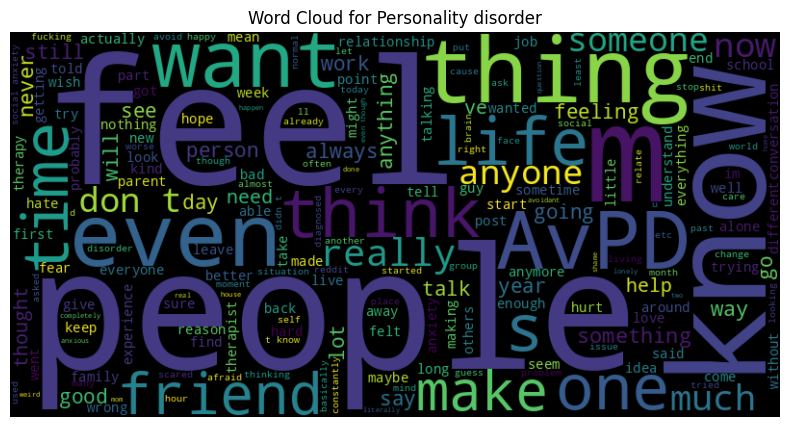

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each status
statuses = df['status'].unique()

for status in statuses:
    status_text = ' '.join(df[df['status'] == status]['statement'])
    generate_word_cloud(status_text, title=f'Word Cloud for {status}')


**Preprocess Text**
Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.



taking a sample of the dataset since the dataset is huge and takes lots of time and energy to process.

In [ ]:
# Taking a sample of the dataframe, e.g., 20,000 rows
sample_size = 20000
df_sample = df.sample(n=sample_size, random_state=1)

In [ ]:

# Load the spacy model
nlp = spacy.load("en_core_web_sm")


In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

     # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Process text with spacy
    doc = nlp(text)

    # Lemmatize and remove stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    # Join the tokens back into a single string
    return ' '.join(tokens)

In [ ]:
def preprocess_texts(texts):
    return [preprocess_text(text) for text in texts]

# Split the data into batches for multiprocessing
num_cores = cpu_count()
df_split = np.array_split(df_sample, num_cores)

# Create a multiprocessing Pool
with Pool(num_cores) as pool:
    # Preprocess the text in parallel
    results = pool.map(preprocess_texts, [batch['statement'].tolist() for batch in df_split])

# Combine the results
df_sample['cleaned_statement'] = [item for sublist in results for item in sublist]

# Display the first few rows of the DataFrame to confirm the changes
print(df_sample[['statement', 'cleaned_statement']].head())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


                                               statement  \
39488  i m and i have bad anxiety debilitating i have...   
1480   Jessica starred in the musical "Legally Blonde...   
47948  I’m so tired I just don’t see a point to my su...   
19681  My life 1 year ago was completely different. I...   
37629  RT @no_onespecixl: Know one enjoys my company ...   

                                       cleaned_statement  
39488  m bad anxiety debilitate haven t able job wa p...  
1480   jessica star musical legally blonde elle wood ...  
47948  tired point suffering understand want know wro...  
19681  life 1 year ago completely different chick mag...  
37629  rt noonespecixl know enjoy company miserable w...  


In [ ]:
df_sample.head()

,Unnamed: 0,statement,status,statement_length,cleaned_statement
39488,39488,i m and i have bad anxiety debilitating i have...,Depression,1697,m bad anxiety debilitate haven t able job wa p...
1480,1480,"Jessica starred in the musical ""Legally Blonde...",Normal,91,jessica star musical legally blonde elle wood ...
47948,47948,I’m so tired I just don’t see a point to my su...,Depression,711,tired point suffering understand want know wro...
19681,19681,My life 1 year ago was completely different. I...,Suicidal,1269,life 1 year ago completely different chick mag...
37629,37629,RT @no_onespecixl: Know one enjoys my company ...,Suicidal,107,rt noonespecixl know enjoy company miserable w...


In [ ]:
# Extract features and labels
processedtext = df_sample['cleaned_statement']
sentiment = df_sample['status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size=0.05, random_state=0)

In [ ]:
print(f'X_train size: {len(X_train)}')
print(f'X_test size: {len(X_test)}')
print(f'y_train size: {len(y_train)}')
print(f'y_test size: {len(y_test)}')

X_train size: 19000
X_test size: 1000
y_train size: 19000
y_test size: 1000


TF-IDF Vectoriser

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It combines two metrics:

Term Frequency (TF): Measures how frequently a term appears in a document.
Inverse Document Frequency (IDF): Assesses the importance of a term by measuring how common or rare it is across the entire corpus.
The TF-IDF score increases with the number of times a word appears in a document but is offset by the frequency of the word in the corpus. This helps to highlight important words that are unique to a document while down-weighting common words.

Why Use TF-IDF?
Feature Extraction: Converts text data into numerical features suitable for machine learning algorithms.
Highlighting Relevance: Emphasizes unique and significant terms while reducing the weight of common terms.
Text Analysis: Widely used in text classification, information retrieval, and natural language processing tasks.

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  457177


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
# Use SMOTE to oversample the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
gb_model.fit(X_train_resampled, y_train_resampled)

y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting Report")
print(classification_report(y_test, y_pred_gb))


In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_resampled_encoded = label_encoder.fit_transform(y_train_resampled)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled_encoded)

# Transform the test target variable for evaluation
y_test_encoded = label_encoder.transform(y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Report")
print(classification_report(y_test_encoded, y_pred_xgb))

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_lgb = lgb_model.predict(X_test)
print("LightGBM Report")
print(classification_report(y_test, y_pred_lgb))


In [ ]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_resampled, y_train_resampled)

y_pred_svm = svm_model.predict(X_test)
print("SVM Report")
print(classification_report(y_test, y_pred_svm))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

adaboost_model.fit(X_train_resampled, y_train_resampled)
y_pred_ada = adaboost_model.predict(X_test)

print("AdaBoost Classifier Report")
print(classification_report(y_test, y_pred_ada))


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classifier Report")
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier Report
                      precision    recall  f1-score   support

             Anxiety       0.88      0.56      0.68        75
             Bipolar       0.91      0.38      0.54        55
          Depression       0.61      0.70      0.65       284
              Normal       0.71      0.98      0.82       310
Personality disorder       1.00      0.27      0.43        22
              Stress       1.00      0.14      0.25        50
            Suicidal       0.67      0.54      0.60       204

            accuracy                           0.69      1000
           macro avg       0.83      0.51      0.57      1000
        weighted avg       0.72      0.69      0.67      1000



In [ ]:
# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

# Initialize the model
bnb = BernoulliNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=bnb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

# Train the model with the best parameters
best_bnb = grid_search.best_estimator_
best_bnb.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_best_bnb = best_bnb.predict(X_test)

# Evaluate the model
print("Tuned Bernoulli Naive Bayes")
print(classification_report(y_test, y_pred_best_bnb))

Best Parameters: {'alpha': 0.1}
Best Score: 0.8088682960274746
Tuned Bernoulli Naive Bayes
                      precision    recall  f1-score   support

             Anxiety       0.88      0.28      0.42        75
             Bipolar       1.00      0.05      0.10        55
          Depression       0.53      0.58      0.55       284
              Normal       0.54      0.99      0.70       310
Personality disorder       1.00      0.23      0.37        22
              Stress       1.00      0.10      0.18        50
            Suicidal       0.66      0.26      0.38       204

            accuracy                           0.56      1000
           macro avg       0.80      0.36      0.39      1000
        weighted avg       0.64      0.56      0.51      1000



Building Models

we got only 56 percent accuracy from the model BernoulliNB

### Conclusion

In this notebook, we tackled a sentiment analysis problem using the Bernoulli Naive Bayes model. Here is a summary of our approach and findings:

1. **Data Preprocessing**:
   - We began by preprocessing our text data, which included cleaning the text, removing noise, and transforming the text data into numerical features using the TF-IDF vectorizer. We optimized the TF-IDF vectorizer parameters to capture important n-grams and limit the feature space.

2. **Handling Class Imbalance**:
   - To address the class imbalance in our dataset, we employed the Synthetic Minority Over-sampling Technique (SMOTE). This helped in balancing the training data by oversampling the minority classes, thus improving the model's ability to learn from these classes.

3. **Model Selection and Hyperparameter Tuning**:
   - We trained the Bernoulli Naive Bayes model and conducted hyperparameter tuning using GridSearchCV to find the optimal `alpha` parameter.

4. **Model Evaluation**:
   - The model was evaluated using metrics such as precision, recall, F1-score, and accuracy.
   - The Bernoulli Naive Bayes model achieved an accuracy of 56%. While this shows the model has some predictive capability, it also indicates significant room for improvement.

### Findings

- **Bernoulli Naive Bayes**:
  - The Bernoulli Naive Bayes model, after hyperparameter tuning and class balancing, showed moderate performance. While it managed to achieve an accuracy of 56%, it struggled with accurately predicting some of the minority classes, highlighting the challenges inherent in dealing with imbalanced datasets.

### Future Work

To further improve the performance of our model, we can consider the following steps:
- **Feature Engineering**: Experiment with additional features such as word embeddings (e.g., Word2Vec, GloVe) or more advanced vectorization techniques like BERT embeddings.
- **Model Exploration**: Try other advanced models such as deep learning models (LSTM, CNN) or transformer-based models (BERT, RoBERTa) that have shown great success in text classification tasks.
- **Hyperparameter Tuning**: Conduct a more exhaustive search for hyperparameters using techniques like RandomizedSearchCV or Bayesian optimization.
- **Ensemble Methods**: Combine multiple models to create an ensemble that could leverage the strengths of different models for improved performance.

### Final Remarks

This project provided valuable insights into the challenges and solutions for sentiment analysis using machine learning models. By systematically preprocessing the data, handling class imbalance, and selecting appropriate models, we were able to build a classifier that can predict sentiments from text data with a moderate degree of accuracy. The journey from data preprocessing to model evaluation underscores the importance of each step in building robust machine learning models and sets the stage for future improvements and exploration.